In [1]:
from PIL import Image
import torch
from torch import nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from skimage.segmentation import slic
from skimage.util import img_as_float

os.sys.path.append(os.path.dirname(os.path.abspath('')))

from util.attribution_methods.VIT_LRP.ViT_explanation_generator import Baselines
from util.test_methods import RISETestFunctions as RISE
from util.test_methods import RISETestFunctions_VIT as RISE_VIT

from util import model_utils
from util.attribution_methods.VIT_LRP.util.layers_ours import Linear as LRP_Linear
from util.visualization import attr_to_subplot

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    from util.attribution_methods.VIT_LRP.ViT_new_timm import vit_base_patch32_224 as vit_new
    num_patches = 7

    # from util.attribution_methods.VIT_LRP.ViT_new_timm import vit_base_patch16_224 as vit_new
    # num_patches = 14


model = vit_new(pretrained=True).cuda()
explainer = Baselines(model)

normalize = transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]
)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [25]:
# attribution tests
img_hw = 224

klen = 11
ksig = 11
kern = RISE.gkern(klen, ksig)
blur = lambda x: nn.functional.conv2d(x, kern, padding = klen // 2)

RISE_insertion = RISE.RISEMetric(model, img_hw * img_hw, 'ins', int((224 ** 2) / (num_patches ** 2)), substrate_fn = blur)

def ins_test_IPM(img_tensor, saliency_map):
    saliency_map_test = np.abs(np.sum(saliency_map, axis = 2, keepdims = True))
    _, _, raw_score = RISE_insertion.single_run(img_tensor, saliency_map_test, 'cuda:0', max_batch_size = 10)
    return RISE.auc(raw_score) 

RISE_insertion_VIT = RISE_VIT.RISEMetric(model, img_hw * img_hw, 'ins')

def ins_test_APM(img_tensor, saliency_map, patch_mask):
    saliency_map_test = np.abs(np.sum(saliency_map, axis = 2, keepdims = True))
    _, _, raw_score = RISE_insertion_VIT.single_run(img_tensor, saliency_map_test, patch_mask, 'cuda:0', max_batch_size = 10)
    return RISE.auc(raw_score) 

# heatmap
def heatmap_overlap(img, attribution, name):
    attr = attribution.detach().cpu().numpy()
    fig, axs = plt.subplots(1, 1)
    attr_to_subplot(attr, name, axs, cmap = 'jet', norm = 'absolute', blended_image = img)
    return

# heatmap
def heatmap_overlap_axs(img, attr, name, axs, alpha = 1):
    attr = attr.detach().cpu().numpy()
    attr_to_subplot(attr, name, axs, cmap = 'jet', norm = 'absolute', blended_image = img, alpha = alpha)
    return

98.18729758262634 65 sea snake
7.677698880434036


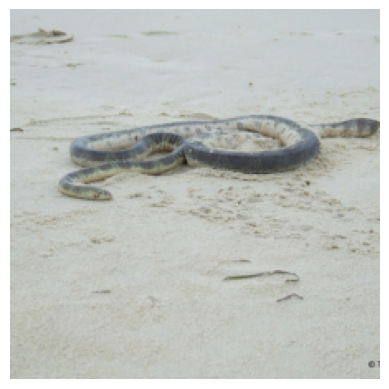

In [29]:
image_path = "../../../ImageNet/ILSVRC2012_val_00000001.JPEG"

image = Image.open(image_path)
if image.mode != "RGB":
    image = image.convert("RGB")
trans_img = transform(image)
tensor_image = normalize(trans_img).unsqueeze(0)

target_class = model_utils.getClass(tensor_image, model, 'cuda:0', k = 0)

with open('../../util/class_maps/ImageNet/imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]
name = classes[target_class]

print(model_utils.getPrediction(tensor_image, model, 'cuda:0', target_class)[0] * 100, target_class.item(), name)
print(model_utils.getPrediction(blur(tensor_image), model, 'cuda:0', target_class)[0] * 100)

plt.imshow(np.transpose(trans_img.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

# segment_count = num_patches ** 2
# n_searches = segment_count
# segment_img = np.transpose(trans_img.squeeze().detach().numpy(), (1, 2, 0))
# segment_img = img_as_float(segment_img)
# patch_mask = torch.tensor(slic(segment_img, n_segments=segment_count, compactness=10000, start_label=0), dtype = int)

patch_ids = torch.arange(num_patches ** 2).reshape((num_patches, num_patches))
patch_mask = patch_ids.repeat_interleave(int(img_hw / num_patches), dim=0).repeat_interleave(int(img_hw / num_patches), dim=1)

In [30]:
resize = transforms.Resize((224, 224), antialias = True)
resize_b = transforms.Resize((224, 224), antialias = True, interpolation=transforms.InterpolationMode.NEAREST_EXACT)
downsize = transforms.Resize((num_patches, num_patches), antialias = True)

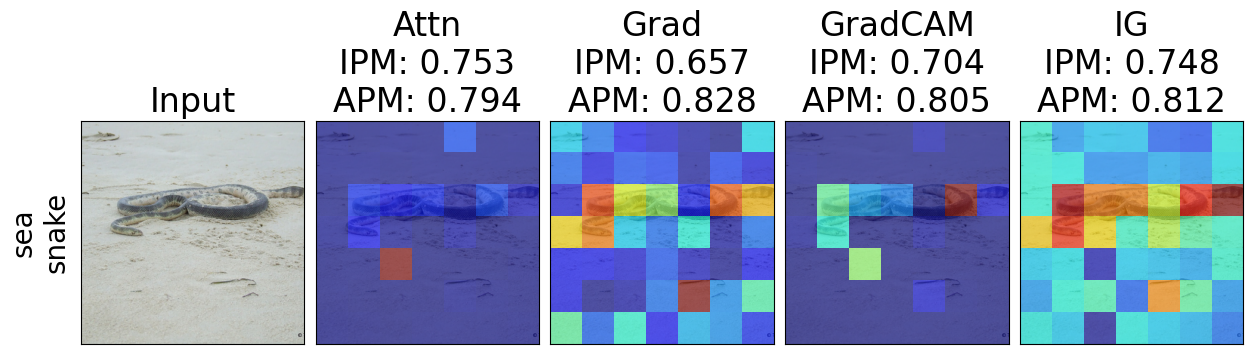

In [31]:
plt.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(1, 5, figsize = (15, 3))

attr_to_subplot(trans_img, "Input", axs[0], original_image = True)
axs[0].set_ylabel(name.replace(" ", "\n"))

attr = explainer.generate_raw_attn(tensor_image.cuda(), "cuda:0")
# attr = resize(attr.cpu().detach())
attr = resize_b(attr.cpu().detach()).permute(1, 2, 0)
vis = heatmap_overlap_axs(trans_img, attr, 'Attn\n' + 'IPM: ' + str(round(ins_test_IPM(tensor_image, attr.numpy()), 3)) + '\nAPM: ' + str(round(ins_test_APM(tensor_image, attr.numpy(), patch_mask), 3)), axs[1], alpha = 0.6)

attr = explainer.generate_grad(tensor_image.cuda(), target_class, "cuda:0")
# attr = resize(attr.cpu().detach())
attr = resize_b(attr.cpu().detach()).permute(1, 2, 0)
vis = heatmap_overlap_axs(trans_img, attr, 'Grad\n' + 'IPM: ' + str(round(ins_test_IPM(tensor_image, attr.numpy()), 3)) + '\nAPM: ' + str(round(ins_test_APM(tensor_image, attr.numpy(), patch_mask), 3)), axs[2], alpha = 0.6)

attr = explainer.generate_cam_attn(tensor_image.cuda(), target_class, "cuda:0")
# attr = resize(attr.cpu().detach())
attr = resize_b(attr.cpu().detach()).permute(1, 2, 0)
vis = heatmap_overlap_axs(trans_img, attr, 'GradCAM\n' + 'IPM: ' + str(round(ins_test_IPM(tensor_image, attr.numpy()), 3)) + '\nAPM: ' + str(round(ins_test_APM(tensor_image, attr.numpy(), patch_mask), 3)), axs[3], alpha = 0.6)

attr = explainer.IG(tensor_image.cuda(), target_class, 50, "cuda:0")
# attr = resize(attr.cpu().detach())
attr = resize_b(attr.cpu().detach()).permute(1, 2, 0)
vis = heatmap_overlap_axs(trans_img, attr, 'IG\n' + 'IPM: ' + str(round(ins_test_IPM(tensor_image, attr.numpy()), 3)) + '\nAPM: ' + str(round(ins_test_APM(tensor_image, attr.numpy(), patch_mask), 3)), axs[4], alpha = 0.6)

plt.subplots_adjust(hspace = 0.12, wspace = 0.05)
plt.show()
